In [2]:
%matplotlib inline

In [3]:
import mne
import pathlib
import numpy as np
from matplotlib import pyplot as plt, ticker

plt.style.use("minimal.mplstyle")
mne.viz.set_browser_backend("matplotlib")

Using matplotlib as 2D backend.


In [4]:
RAW_DATA_PATH = pathlib.Path("../data/EEG")

SESSIONS = [
    "group13_own",
    # "group13b_own"
]

---

In [5]:
epochs_per_participant = [mne.read_epochs(RAW_DATA_PATH.joinpath(SESSION + "-epo.fif")) for SESSION in SESSIONS]
all_epochs = mne.concatenate_epochs(epochs_per_participant)

Reading /work/DanielAakjærLundgaard#0515/AuthorshipArtifice/analysis/../data/EEG/group13_own-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
10988 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_5513/3415278017.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epochs_per_participant)


Not setting metadata
10988 matching events found
Applying baseline correction (mode: mean)


# Comparing evoked GFPs

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


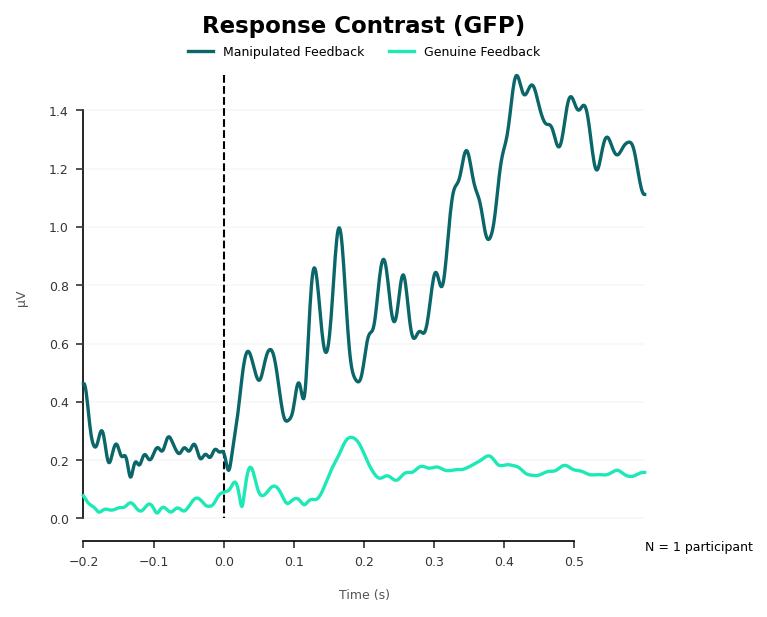

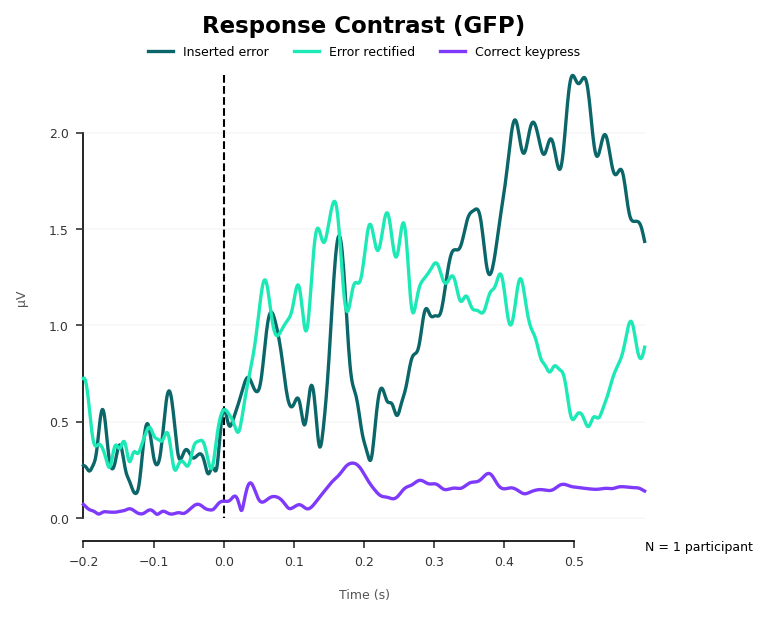

In [6]:
def compare_evoked_activity(conditions, participant_selection = "all"):
    included_epochs = all_epochs
    amount_participants_included = len(epochs_per_participant)

    fig = mne.viz.plot_compare_evokeds(
        evokeds={condition: included_epochs[event_keys].average() for condition, event_keys in conditions.items()},
        ci = 0.95,
        combine = "gfp",
        title = "Response Contrast",
        show = False
    )[0]
    fig.set_size_inches((5, 4))
    ax = fig.axes[0]
    ax.autoscale()
    ax.get_legend().remove()
    ax.legend(
        ncol = len(conditions),
        labels = conditions.keys(), 
        bbox_to_anchor = (0.5, 1.04), 
        loc = "upper center"
    )
    ax.annotate(
        f"""N = {amount_participants_included} participant{"s" if amount_participants_included > 1 else ""}""",
        xy = (1, 0),
        xycoords = "axes fraction",
        va = "top"
    )

compare_evoked_activity(
    conditions = {
        "Manipulated Feedback": ("error inserted", "error rectified"),
        "Genuine Feedback": ("correct", "incorrect"),
    },
    participant_selection=[1]
)

compare_evoked_activity(
    conditions = {
        "Inserted error": ["error inserted"],
        "Error rectified": ["error rectified"],
        "Correct keypress": ["correct"],
    }
)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 30


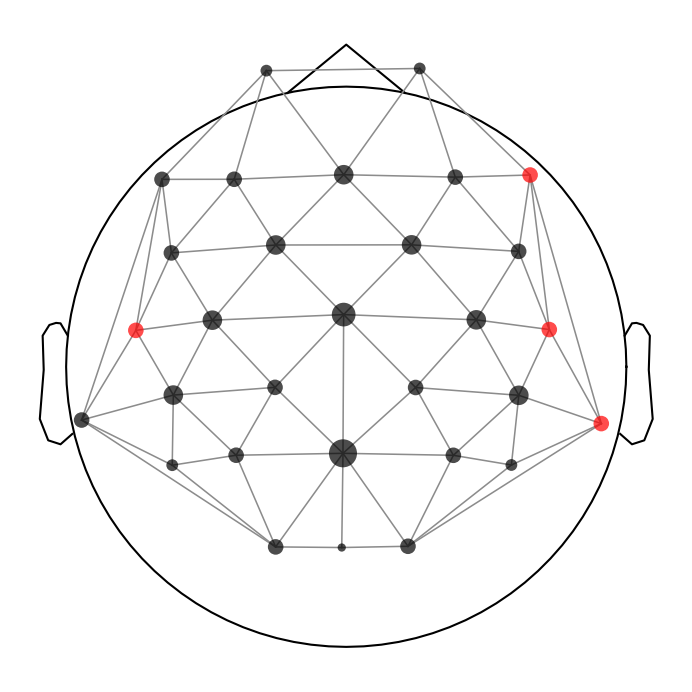

In [7]:
adjacency, ch_names = mne.channels.find_ch_adjacency(all_epochs.info, ch_type="eeg")
mne.viz.plot_ch_adjacency(all_epochs.info, adjacency, ch_names);

# Cluster-based permutation analysis

Using a threshold of 3.843153


/tmp/ipykernel_5513/2311647242.py:7: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(


stat_fun(H1): min=0.000000 max=241.376265
Running initial clustering …
Found 10 clusters


  0%|          | Permuting : 0/499 [00:00<?,       ?it/s]

Using a threshold of 3.843153


/tmp/ipykernel_5513/2311647242.py:7: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(


stat_fun(H1): min=0.000000 max=54.922646
Running initial clustering …
Found 28 clusters


  0%|          | Permuting : 0/499 [00:00<?,       ?it/s]

Using a threshold of 3.861363
stat_fun(H1): min=0.000000 max=21.727009
Running initial clustering …


/tmp/ipykernel_5513/2311647242.py:7: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(


Found 28 clusters


  0%|          | Permuting : 0/499 [00:00<?,       ?it/s]

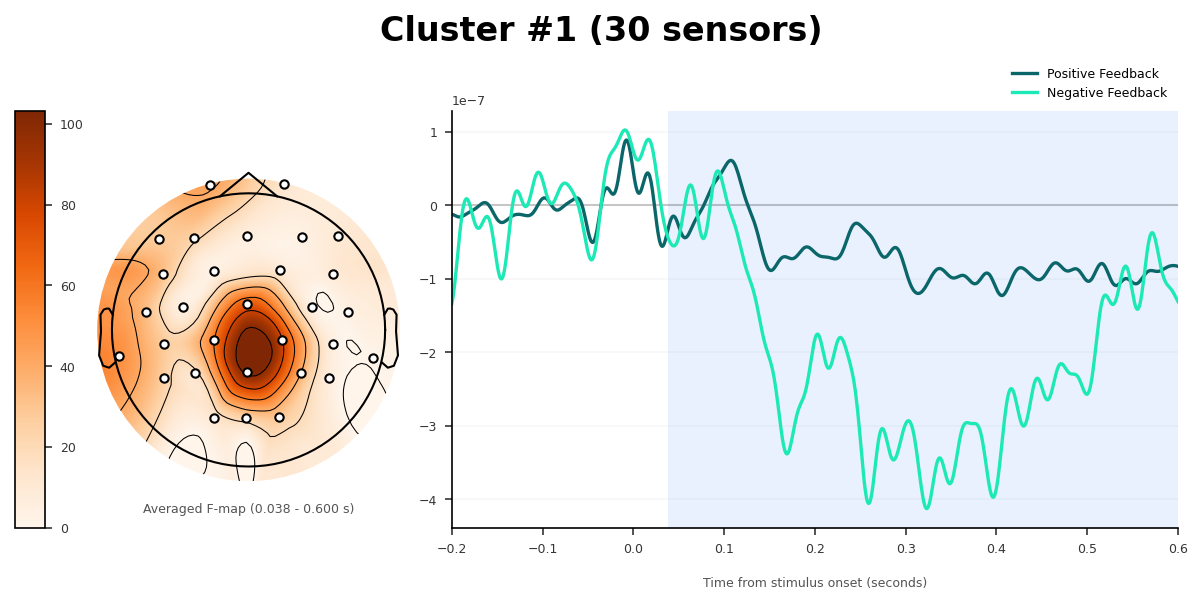

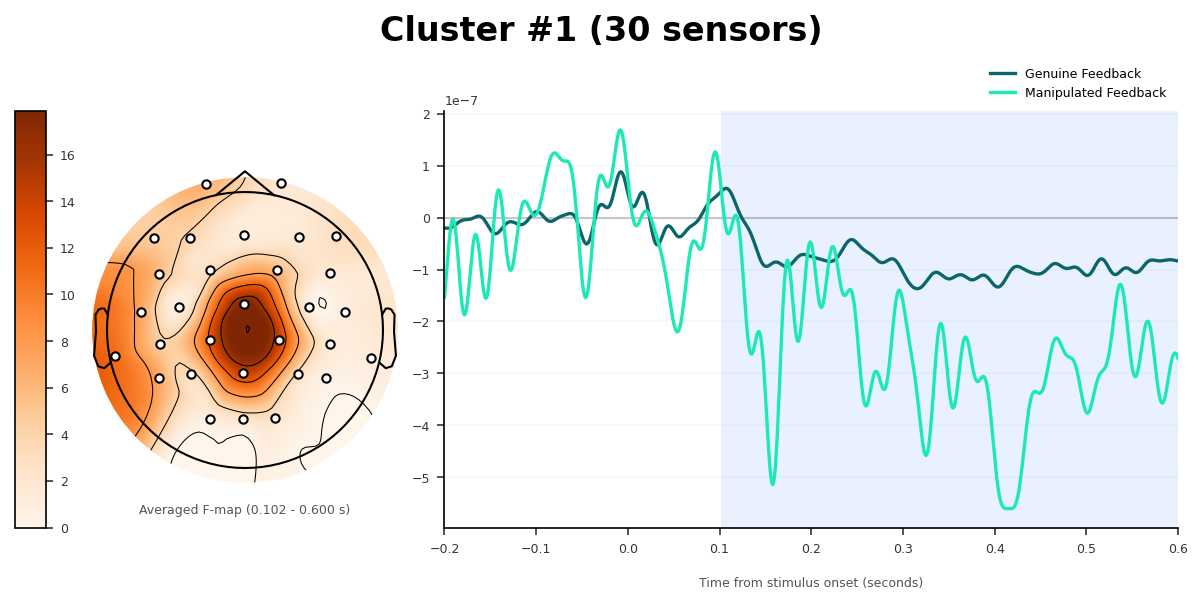

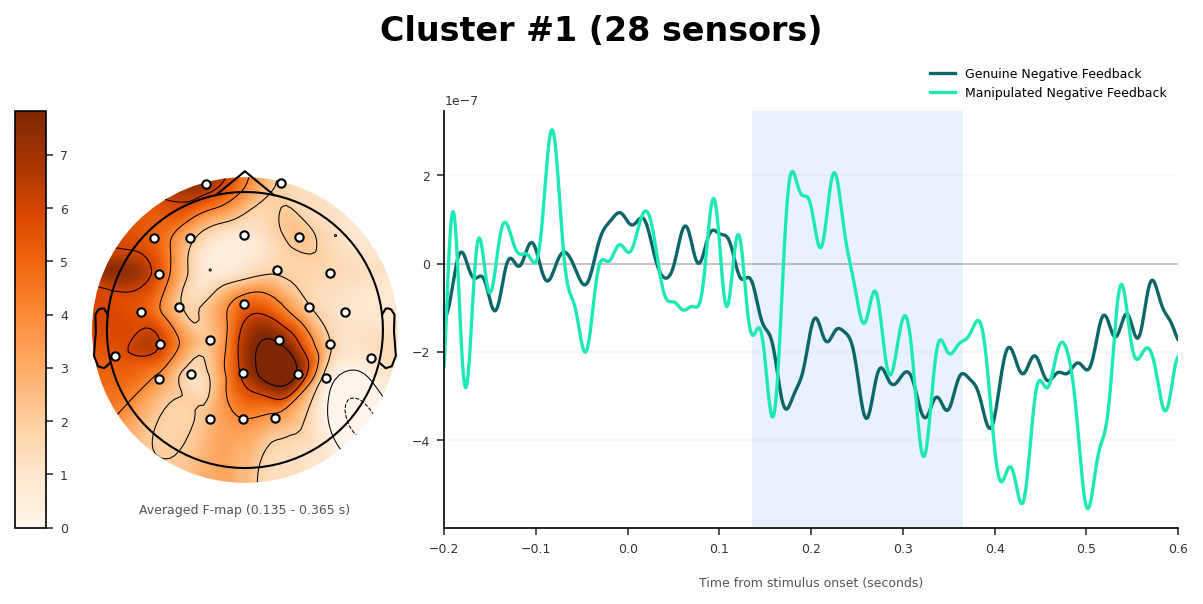

In [8]:
def perform_cluster_permutation(conditions, p_threshold = 0.05):
    def transpose_data(epochs): 
        return np.transpose(epochs.get_data(copy = True), (0, 2, 1))

    transposed_data = [transpose_data(all_epochs[condition]) for condition in conditions.values()]

    F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(
        X = transposed_data,
        n_permutations=500, 
        adjacency=adjacency, 
        seed=69,
        n_jobs=-1, 
    )

    selected_clusters = [cluster for cluster, p_val in zip(clusters, p_values) if p_val < p_threshold]
    if not len(selected_clusters):
        print("No clusters reached set significance threshold of", p_threshold)
    else:
        for cluster_id, cluster in enumerate(selected_clusters):
            time_inds, space_inds = np.squeeze(cluster)
            ch_inds = np.unique(space_inds)
            time_inds = np.unique(time_inds)

            f_map = F_obs[time_inds, ...].mean(axis=0) # topography for stats
            sig_times = all_epochs.times[time_inds] # signals at the sensors contributing to the cluster

            mask = np.zeros((f_map.shape[0], 1), dtype=bool) # creating spatial mask
            mask[ch_inds, :] = True

            fig, (ax_colorbar, ax_topography, ax_signals) = plt.subplots(
                ncols = 3, 
                figsize=(8, 4), 
                width_ratios = [0.1, 1, 2.4], 
            )
            fig.suptitle(f"Cluster #{cluster_id + 1} ({len(ch_inds)} sensors)")

            image = mne.viz.plot_topomap(
                f_map,
                all_epochs.info,
                axes=ax_topography,
                cmap="Oranges",
                show=False,
                mask=mask
            )
            fig.colorbar(image[0], fraction = 0.6, cax = ax_colorbar)
            ax_topography.set_xlabel(f"Averaged F-map ({sig_times[0]:0.3f} - {sig_times[-1]:0.3f} s)")

            ax_signals.axhline(
                y = 0, 
                color = "black",
                linewidth = 1,
                alpha = 0.2
            )
            for condition, cluster_signal in zip(conditions.keys(), transposed_data):
                ax_signals.plot(
                    all_epochs.times, 
                    cluster_signal[:, :, ch_inds].mean(axis=(0, 2)),
                    label=condition
                )
            ax_signals.legend(loc = "lower right", bbox_to_anchor = (1, 1))
            ax_signals.set_xlabel("Time from stimulus onset (seconds)")
            
            ax_signals.axvspan(
                sig_times[0], 
                sig_times[-1], 
                facecolor="C6", 
                alpha=0.1
            )

        plt.tight_layout()

perform_cluster_permutation(
    conditions = {
        "Positive Feedback": ("correct", "error rectified"),
        "Negative Feedback": ("incorrect", "error inserted")
    },
    p_threshold = 0.05
)
perform_cluster_permutation(
    conditions = {
        "Genuine Feedback": ("correct", "incorrect"),
        "Manipulated Feedback": ("error inserted", "error rectified")
    },
    p_threshold = 0.05
)
perform_cluster_permutation(
    conditions = {
        "Genuine Negative Feedback": ("incorrect"),
        "Manipulated Negative Feedback": ("error inserted")
    },
    p_threshold = 0.05
)

# Cluster-based permutation analysis across full participant cohort

In [10]:
# def perform_cluster_permutation(conditions, p_threshold = 0.05):
#     def mould_data(events):
#         averaged_trials_per_participant = [participant[events].get_data(copy = True).mean(axis = 0).transpose() for participant in epochs_per_participant]
#         return np.concatenate([np.expand_dims(averaged, axis = 0) for averaged in averaged_trials_per_participant], axis = 0)

#     moulded_data = [mould_data(events) for events in conditions.values()]
#     print("{} participants across {} events across {} sensors".format(*moulded_data[0].shape))

#     F_obs, clusters, p_values, H0 = mne.stats.spatio_temporal_cluster_test(
#         X = moulded_data,
#         n_permutations=500, 
#         adjacency=adjacency, 
#         seed=69,
#         n_jobs=-1, 
#     )

#     selected_clusters = [cluster for cluster, p_val in zip(clusters, p_values) if p_val < p_threshold]
#     if not len(selected_clusters):
#         print("No clusters reached set significance threshold of", p_threshold)
#     else:
#         for cluster_id, cluster in enumerate(selected_clusters):
#             time_inds, space_inds = np.squeeze(cluster)
#             ch_inds = np.unique(space_inds)
#             time_inds = np.unique(time_inds)

#             f_map = F_obs[time_inds, ...].mean(axis=0) # topography for stats
#             sig_times = all_epochs.times[time_inds] # signals at the sensors contributing to the cluster

#             mask = np.zeros((f_map.shape[0], 1), dtype=bool) # creating spatial mask
#             mask[ch_inds, :] = True

#             fig, (ax_colorbar, ax_topography, ax_signals) = plt.subplots(
#                 ncols = 3, 
#                 figsize=(8, 4), 
#                 width_ratios = [0.1, 1, 2.4], 
#             )
#             fig.suptitle(f"Cluster #{cluster_id + 1} ({len(ch_inds)} sensors)")

#             image = mne.viz.plot_topomap(
#                 f_map,
#                 all_epochs.info,
#                 axes=ax_topography,
#                 cmap="Oranges",
#                 show=False,
#                 mask=mask
#             )
#             fig.colorbar(image[0], fraction = 0.6, cax = ax_colorbar)
#             ax_topography.set_xlabel(f"Averaged F-map ({sig_times[0]:0.3f} - {sig_times[-1]:0.3f} s)")

#             ax_signals.axhline(
#                 y = 0, 
#                 color = "black",
#                 linewidth = 1,
#                 alpha = 0.2
#             )
#             for condition, cluster_signal in zip(conditions.keys(), moulded_data):
#                 ax_signals.plot(
#                     all_epochs.times, 
#                     cluster_signal[:, :, ch_inds].mean(axis=(0, 2)),
#                     label=condition
#                 )
#             ax_signals.legend(loc = "lower right", bbox_to_anchor = (1, 1))
#             ax_signals.set_xlabel("Time from stimulus onset (seconds)")
            
#             ax_signals.axvspan(
#                 sig_times[0], 
#                 sig_times[-1], 
#                 facecolor="C6", 
#                 alpha=0.1
#             )

#         plt.tight_layout()

# perform_cluster_permutation(
#     conditions = {
#         "Positive Feedback": ("correct", "error rectified"),
#         "Negative Feedback": ("incorrect", "error inserted")
#     },
#     p_threshold = 0.05
# )
# perform_cluster_permutation(
#     conditions = {
#         "Genuine Feedback": ("correct", "incorrect"),
#         "Manipulated Feedback": ("error inserted", "error rectified")
#     },
#     p_threshold = 0.05
# )
# perform_cluster_permutation(
#     conditions = {
#         "Genuine Negative Feedback": ("incorrect"),
#         "Manipulated Negative Feedback": ("error inserted")
#     },
#     p_threshold = 0.05
# )